In [1]:
import cvxopt as cvx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as dt

In [2]:
# read data into memory
images_data_set = np.genfromtxt("hw06_images.csv", delimiter = ",")
labels_data_set = np.genfromtxt("hw06_labels.csv", delimiter = ",").astype(int)

In [3]:
# divide data set into two parts: training set and test set
x_training = images_data_set[0:1000, :]
x_test = images_data_set[1000:, :]
y_training = labels_data_set[0:1000]
y_test = labels_data_set[1000:]

In [4]:
# get number of classes
K = np.max(y_training)

# get number of samples and number of features
N_training = len(y_training)
N_test = len(y_test)

In [5]:
# define Gaussian kernel function
def gaussian_kernel(X1, X2, s):
    D = dt.cdist(X1, X2)
    K = np.exp(-D**2 / (2 * s**2))
    return(K)

In [6]:
def SVM(Y, C):
    yyK = np.matmul(Y[:,None], Y[None,:]) * K_training
    
    P = cvx.matrix(yyK)
    q = cvx.matrix(-np.ones((N_training, 1)))
    G = cvx.matrix(np.vstack((-np.eye(N_training), np.eye(N_training))))
    h = cvx.matrix(np.vstack((np.zeros((N_training, 1)), C * np.ones((N_training, 1)))))
    A = cvx.matrix(1.0 * Y[None,:])
    b = cvx.matrix(0.0)
    
    # use cvxopt library to solve QP problems
    result = cvx.solvers.qp(P, q, G, h, A, b)
    alpha = np.reshape(result["x"], N_training)
    alpha[alpha < C * epsilon] = 0
    alpha[alpha > C * (1 - epsilon)] = C

    # find bias parameter
    support_indices, = np.where(alpha != 0)
    active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
    w0 = np.mean(Y[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))
    
    return alpha, w0

In [7]:
s = 10
C = 10
epsilon = 1e-3

# calculate Gaussian kernel
K_training = gaussian_kernel(x_training, x_training, s)

SVM_alphas = []
SVM_w0s = []
for i in range (K):
    y_adjusted = np.ones(y_training.shape[0])
    y_adjusted[y_training != i+1] = -1
    alpha, w0 = SVM(y_adjusted, C)
    SVM_alphas.append(alpha)
    SVM_w0s.append(w0)
SVM_alphas = np.array(SVM_alphas)
SVM_w0s = np.array(SVM_w0s)

     pcost       dcost       gap    pres   dres
 0:  2.9600e+01 -4.2260e+04  8e+04  4e-01  3e-14
 1:  1.2992e+01 -7.4611e+03  8e+03  2e-02  4e-14
 2: -6.2643e+02 -2.9089e+03  2e+03  4e-03  3e-14
 3: -8.9105e+02 -1.7204e+03  8e+02  1e-03  4e-14
 4: -1.0255e+03 -1.3482e+03  3e+02  2e-04  4e-14
 5: -1.0893e+03 -1.1778e+03  9e+01  2e-05  5e-14
 6: -1.1096e+03 -1.1353e+03  3e+01  3e-07  5e-14
 7: -1.1169e+03 -1.1209e+03  4e+00  7e-14  5e-14
 8: -1.1184e+03 -1.1185e+03  1e-01  9e-14  5e-14
 9: -1.1185e+03 -1.1185e+03  4e-03  1e-13  5e-14
10: -1.1185e+03 -1.1185e+03  7e-05  1e-13  5e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9161e+02 -4.0951e+04  8e+04  4e-01  2e-14
 1:  1.7375e+02 -7.6611e+03  9e+03  2e-02  3e-14
 2: -4.0615e+02 -2.9616e+03  3e+03  6e-03  3e-14
 3: -6.2557e+02 -1.7531e+03  1e+03  2e-03  3e-14
 4: -7.5417e+02 -1.1618e+03  4e+02  4e-04  3e-14
 5: -8.2696e+02 -9.7495e+02  1e+02  6e-14  3e-14
 6: -8.5262e+02 -8.9665e+02  4e+01  2e-16  3e-1

In [8]:
# calculate predictions on training samples
scores = []
for i in range(K):
    y_adjusted = np.ones(y_training.shape[0])
    y_adjusted[y_training != i+1] = -1
    f_predicted = np.matmul(K_training, y_adjusted[:,None] * SVM_alphas[i][:,None]) + SVM_w0s[i]
    f_predicted = np.squeeze(f_predicted)
    scores.append(f_predicted)
scores = np.array(scores)

y_predicted = np.argmax(scores, axis=0)
y_predicted = y_predicted + 1

# calculate confusion matrix
confusion_matrix = pd.crosstab(np.reshape(y_predicted, N_training), y_training, rownames = ['y_predicted'], colnames = ['y_train'])
print(confusion_matrix)

y_train        1    2    3    4    5
y_predicted                         
1            207    1    0    9    0
2              2  199    1    1    0
3              0    1  204    6    0
4              0    1    4  185    1
5              0    0    0    0  178


In [9]:
K_test = gaussian_kernel(x_test, x_training, s)

# calculate predictions on test samples
scores = []
for i in range(K):
    y_adjusted = np.ones(y_training.shape[0])
    y_adjusted[y_training != i+1] = -1
    f_predicted = np.matmul(K_test, y_adjusted[:,None] * SVM_alphas[i][:,None]) + SVM_w0s[i]
    f_predicted = np.squeeze(f_predicted)
    scores.append(f_predicted)
scores = np.array(scores)

y_predicted = np.argmax(scores, axis=0)
y_predicted = y_predicted + 1

# calculate confusion matrix
confusion_matrix = pd.crosstab(np.reshape(y_predicted, N_test), y_test, rownames = ['y_predicted'], colnames = ['y_test'])
print(confusion_matrix)

y_test         1    2    3    4    5
y_predicted                         
1            641   23    3  137    9
2             43  714   27   40    4
3              4   39  666   90   10
4            100   32   69  541   16
5             12    2    6   15  757


In [10]:
def calc_accuracy(C):
    SVM_alphas = []
    SVM_w0s = []
    for i in range (K):
        y_adjusted = np.ones(y_training.shape[0])
        y_adjusted[y_training != i+1] = -1
        alpha, w0 = SVM(y_adjusted, C)
        SVM_alphas.append(alpha)
        SVM_w0s.append(w0)
    SVM_alphas = np.array(SVM_alphas)
    SVM_w0s = np.array(SVM_w0s)
    
    # calculate predictions on training samples
    scores = []
    for i in range(K):
        y_adjusted = np.ones(y_training.shape[0])
        y_adjusted[y_training != i+1] = -1
        f_predicted = np.matmul(K_training, y_adjusted[:,None] * SVM_alphas[i][:,None]) + SVM_w0s[i]
        f_predicted = np.squeeze(f_predicted)
        scores.append(f_predicted)
    scores = np.array(scores)

    y_predicted = np.argmax(scores, axis=0)
    y_predicted = y_predicted + 1
    
    train_accuracy = np.sum(y_predicted == y_training) / len(y_training)
    
    # calculate predictions on test samples
    scores = []
    for i in range(K):
        y_adjusted = np.ones(y_training.shape[0])
        y_adjusted[y_training != i+1] = -1
        f_predicted = np.matmul(K_test, y_adjusted[:,None] * SVM_alphas[i][:,None]) + SVM_w0s[i]
        f_predicted = np.squeeze(f_predicted)
        scores.append(f_predicted)
    scores = np.array(scores)

    y_predicted = np.argmax(scores, axis=0)
    y_predicted = y_predicted + 1
    
    test_accuracy = np.sum(y_predicted == y_test) / len(y_test)
    
    return train_accuracy, test_accuracy

In [11]:
training_accuracy = []
test_accuracy = []
for C in [1e-1, 1e0, 1e1, 1e2, 1e3]:
    training, test = calc_accuracy(C)
    training_accuracy.append(training)
    test_accuracy.append(test)

     pcost       dcost       gap    pres   dres
 0: -1.3936e+02 -2.2047e+02  7e+03  3e+01  3e-15
 1: -3.4801e+01 -2.0264e+02  4e+02  9e-01  3e-15
 2: -2.8151e+01 -7.9601e+01  5e+01  1e-15  1e-15
 3: -3.1266e+01 -4.3423e+01  1e+01  2e-16  1e-15
 4: -3.2572e+01 -3.9120e+01  7e+00  4e-16  1e-15
 5: -3.3423e+01 -3.6637e+01  3e+00  1e-15  1e-15
 6: -3.3666e+01 -3.6029e+01  2e+00  7e-16  1e-15
 7: -3.4121e+01 -3.4971e+01  9e-01  2e-15  1e-15
 8: -3.4319e+01 -3.4585e+01  3e-01  2e-16  1e-15
 9: -3.4415e+01 -3.4445e+01  3e-02  2e-16  1e-15
10: -3.4429e+01 -3.4430e+01  1e-03  2e-15  1e-15
11: -3.4429e+01 -3.4429e+01  5e-05  7e-16  1e-15
12: -3.4429e+01 -3.4429e+01  1e-06  2e-15  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1812e+02 -2.1835e+02  7e+03  3e+01  2e-15
 1: -3.1287e+01 -2.0015e+02  5e+02  1e+00  2e-15
 2: -2.4529e+01 -8.1514e+01  6e+01  9e-16  2e-15
 3: -2.7550e+01 -4.0807e+01  1e+01  2e-15  1e-15
 4: -2.8779e+01 -3.6453e+01  8e+00  4e-16  1e-1

 7: -1.0296e+03 -1.0480e+03  2e+01  1e-13  4e-14
 8: -1.0350e+03 -1.0380e+03  3e+00  1e-13  4e-14
 9: -1.0360e+03 -1.0362e+03  2e-01  1e-13  4e-14
10: -1.0361e+03 -1.0361e+03  4e-03  7e-14  4e-14
11: -1.0361e+03 -1.0361e+03  7e-05  1e-13  4e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.0057e+02 -5.0242e+04  8e+04  3e-01  4e-14
 1: -5.5603e+02 -8.9813e+03  9e+03  1e-02  5e-14
 2: -1.3487e+03 -3.4368e+03  2e+03  2e-03  5e-14
 3: -1.6731e+03 -2.5433e+03  9e+02  3e-04  5e-14
 4: -1.8026e+03 -2.1922e+03  4e+02  6e-05  6e-14
 5: -1.8680e+03 -1.9850e+03  1e+02  8e-06  6e-14
 6: -1.8927e+03 -1.9224e+03  3e+01  7e-07  6e-14
 7: -1.9008e+03 -1.9050e+03  4e+00  6e-14  6e-14
 8: -1.9023e+03 -1.9024e+03  1e-01  7e-15  6e-14
 9: -1.9023e+03 -1.9023e+03  2e-03  6e-14  6e-14
10: -1.9023e+03 -1.9023e+03  5e-05  1e-13  6e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.0372e+02 -3.9006e+04  9e+04  4e-01  1e-14
 1:  8.8098e+02 -6.5835

     pcost       dcost       gap    pres   dres
 0:  1.6092e+07 -3.6559e+08  5e+08  2e-01  4e-12
 1:  1.1537e+07 -6.1870e+07  8e+07  2e-02  6e-12
 2:  4.8978e+06 -1.8971e+07  2e+07  6e-03  4e-12
 3:  1.7138e+06 -6.8321e+06  9e+06  7e-04  4e-12
 4:  5.3680e+05 -2.3698e+06  3e+06  2e-12  3e-12
 5:  2.3023e+05 -1.0554e+06  1e+06  7e-13  2e-12
 6:  9.0450e+04 -4.3818e+05  5e+05  1e-13  1e-12
 7:  1.1082e+04 -3.9758e+04  5e+04  8e-13  9e-13
 8: -9.7930e+02 -8.9481e+03  8e+03  2e-13  5e-13
 9: -2.5200e+03 -5.3745e+03  3e+03  3e-14  3e-13
10: -3.1184e+03 -4.0057e+03  9e+02  8e-13  2e-13
11: -3.3092e+03 -3.5607e+03  3e+02  5e-13  2e-13
12: -3.3664e+03 -3.4192e+03  5e+01  2e-13  2e-13
13: -3.3810e+03 -3.3857e+03  5e+00  6e-13  2e-13
14: -3.3824e+03 -3.3826e+03  1e-01  5e-13  2e-13
15: -3.3825e+03 -3.3825e+03  3e-03  1e-14  2e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1108e+07 -2.6385e+08  5e+08  3e-01  1e-12
 1:  9.5530e+06 -3.9025e+07  6e+07  2e-02  2e-1

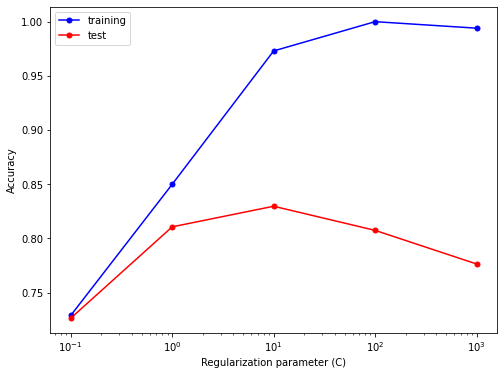

In [12]:
fig = plt.figure(figsize = (8,6))

plt.plot([1e-1, 1e0, 1e1, 1e2, 1e3], training_accuracy, "b.-", label = "training", markersize = 10)
plt.plot([1e-1, 1e0, 1e1, 1e2, 1e3], test_accuracy, "r.-", label = "test", markersize = 10)

plt.xscale("log")
plt.xlabel("Regularization parameter (C)")
plt.ylabel("Accuracy")
plt.legend(loc = "upper left")
plt.show()